In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

In [2]:
# to suppress convergence warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

#### Load Datasets  
- _Change the value of `ds` to change dataset_

In [3]:
# Change this line to change dataset between (ds = 1) and (ds = 2)
ds = 1

info = pd.read_csv('data/info_{0}.csv'. format(ds), index_col=0)
train_data = pd.read_csv('data/train_{0}.csv'.format(ds), header=None)
val_data = pd.read_csv('data/val_{0}.csv'.format(ds), header=None)
test_data = pd.read_csv('data/test_with_label_{0}.csv'.format(ds), header=None)

model_name = 'Best-MLP'
output_csv = "output/{0}-DS{1}.csv".format(model_name, ds)

#### Split data matrices X and targets y

In [4]:
# Data definitions
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_val = val_data.iloc[:, :-1]
y_val = val_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

#join train and validation sets for grid search
X = pd.concat([X_train, X_val], axis=0)
y = pd.concat([y_train, y_val], axis=0)

#### Predefine split of train and validation set

In [5]:
test_fold = np.concatenate([np.repeat(-1, len(X_train.index)), 
                            np.repeat(0, len(X_val.index))], axis = 0)
ps = PredefinedSplit(test_fold=test_fold)

#### Train data

In [6]:
# mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), activation='logistic', solver='sgd').fit(X_train, y_train)
params = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
          'solver': ['adam', 'sgd'],
          'hidden_layer_sizes': [(30, 50), (10, 10, 10)]
         }

clf = GridSearchCV(MLPClassifier(random_state=42), params, n_jobs=-1, cv=ps)
clf.fit(X, y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(30, 50), (10, 10, 10)],
                         'solver': ['adam', 'sgd']})

In [7]:
print(clf.best_params_)

{'activation': 'identity', 'hidden_layer_sizes': (30, 50), 'solver': 'adam'}


#### Make Prediction

In [8]:
y_pred = pd.Series(clf.predict(X_test))
clf.score(X_test, y_test)

0.85

#### Output Prediction

In [9]:
y_pred.to_csv(output_csv, header=None)
y_pred

0      4
1     13
2     21
3      2
4     18
      ..
75    18
76    15
77    17
78     6
79    19
Length: 80, dtype: int64

#### Output Confusion Matrix and Plot

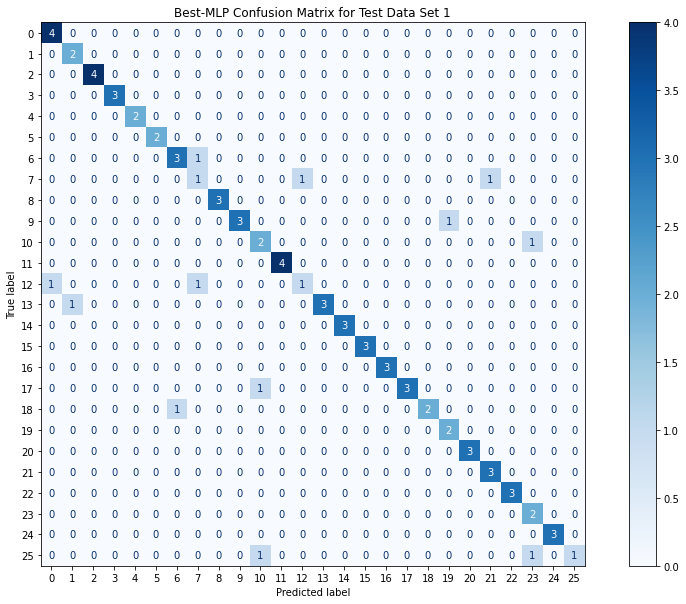

In [10]:
outmatrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(16,10))
plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', ax=ax)
ax.set_title('{0} Confusion Matrix for Test Data Set {1}'.format(model_name, ds))
plt.savefig('img/{0}_confusion_matrix_DS{1}'.format(model_name, ds))
plt.show()

#### Compute Metrics per Class

In [11]:
def compute_metrics(df, y_true, y_pred):
    df_metrics = pd.DataFrame(classification_report(y_true, y_pred, target_names=df['symbol'], output_dict=True, zero_division=0)).T
    df_metrics['symbol'] = df_metrics.index
    df_metrics
    return pd.merge(df, df_metrics, how='right')

info = compute_metrics(info, y_test, y_pred)
info.to_csv(output_csv, mode='a')
info

,symbol,precision,recall,f1-score,support
0,A,0.800000,1.000000,0.888889,4.00
1,B,0.666667,1.000000,0.800000,2.00
2,C,1.000000,1.000000,1.000000,4.00
3,D,1.000000,1.000000,1.000000,3.00
4,E,1.000000,1.000000,1.000000,2.00
5,F,1.000000,1.000000,1.000000,2.00
6,G,0.750000,0.750000,0.750000,4.00
7,H,0.333333,0.333333,0.333333,3.00
8,I,1.000000,1.000000,1.000000,3.00
9,J,1.000000,0.750000,0.857143,4.00


#### Compute Metrics for the Model

In [12]:
def compute_scores(y_test, y_pred):
    return [
        sklearn.metrics.accuracy_score(y_test, y_pred),
        sklearn.metrics.f1_score(y_test, y_pred, average='macro'),
        sklearn.metrics.f1_score(y_test, y_pred, average='weighted')
    ]

model_desc = pd.DataFrame(index=['accuracy', 'macro-average-f1', 'weighted-average-f1'])

model_desc['DS{}'.format(ds)] = compute_scores(y_test, y_pred)
model_desc['DS{}'.format(ds)].to_frame().T.to_csv(output_csv, mode='a')
model_desc # not cumulative since output separately for each ds

,DS1
accuracy,0.850000
macro-average-f1,0.843803
weighted-average-f1,0.847004
